# L-score: If you build it (in a proper location), they will come
#### Jonathan D. Jarvis, Ph.D.
-----
<img align="right" src="http://i.imgur.com/2ZQoksy.png" title="(top) Wabash & Madison in 1964, (bottom) CTA L-system map" width="250">

This notebook explores data from the elevated train system, the "L," in the city of Chicago. Specifically, it considers the question of optimal positioning of new businesses based on turnstile-activation data from each stop on the "L" system.

The activation data is unidirectional in that only station entries are recorded; exits are not. This makes the system highly underdetermined and complicates efforts to extract mappings of passengers between stations. Approximate mappings might be derived using covariance between activity at stations at the extremities of each line, where non-resident entries are less likely, with major stations in the "loop" area (dominant commercial area with high volume "L" stations). Such mappings would be most useful in that one could estimate demographic distributions of the commuters in a given geographic area and develop a value map that is specific to the target demographics of a business's customer base.

In this notebook we look specifically at a simple commuter density model using the station locations as source/sink points. The model includes calibrated terms for pedestrians, cyclists and taxi/car-service riders. For simplicity, the commuter-density map generated by this model is not constrained by appropriate physical boundaries (e.g. the river, Lake Michigan, train tracks etc...). The distributions by which the model is calibrated have a length scale that is large compared to the inter-station separation, which renders the density map rather non-informative.

As an alternative means of estimating commuter density, we incorporate a simple commuter decision model in which a commuter in a given location will alway choose to go to the closest station. This type of discretization is known as a Voronoi diagram. We build these diagrams for two different distance metrics: Euclidean and Manhattan. The Manhattan version is meant to capture the effect of commuters being forced to travel predominantly along the grid-like structure of a major city; i.e. the paths are constrained to be North-South or East-West and the Manhattan distance enforces this explicitly.

Ideally, we will convolve our commuter density model with a value map that uses property values, crime statistics and various other metrics to score geographic areas in the context of a business owner's preferences.  For example, a business owner would probably prefer to avoid areas with property values that are excessively high or excessively low.  An exception, of course, is if the business's product specifically target demographics that are specific to such areas.  For example, consider extremes such as fine jewlers and pay-day lenders.

*image credit: Ray Walker / Chicago Tribune & the CTA*

-----
## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
import random

from IPython.display import display, HTML
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15

#tnrfont = {'family':'serif','serif':['Times New Roman']}
#mpl.rc('font',**{'family':'serif','serif':['Times']})

-----
## Functions

In [59]:
#Center of the universe!
dslat = 41.882692
dslon = -87.626146

def num_missing(x):
    return sum(x.isnull())

def geoconv(xdata, ydata, lat0, lon0):
    #Takes flattened xy-grid data, where lat0-lon0 is the origin, and converts to flattened array 
    #of lat-lon via equirectangular projection
    R_e = 6371.
    lon0, lat0 = map(np.radians, [lon0, lat0])
    lat1 = lat0 + ydata/R_e
    avglat = (lat0 + lat1)/2.
    lon1 = lon0 + xdata/(R_e*np.cos(avglat))
    lon1, lat1 = map(np.degrees, [lon1, lat1])
    return lat1, lon1

def haversine(lat1, lon1, lat2, lon2):
    #Computes the great-circle distance (km) between two lat-lon points (dec. deg)
    #M. Dunn# 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2.)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.)**2
    c = 2. * np.arcsin(np.sqrt(a)) 
    R_e = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * R_e

def haversine_manhattan(lat1, lon1, lat2, lon2):
    #Computes the Manhattan distance (km) between two lat-lon points (dec. deg); uses haversine for each leg
    #M. Dunn# 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a_x = np.cos(lat1)**2 * np.sin(dlon/2.)**2
    c_x = 2. * np.arcsin(np.sqrt(a_x)) 
    a_y = np.sin(dlat/2.)**2
    c_y = 2. * np.arcsin(np.sqrt(a_y)) 
    R_e = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return (c_x + c_y) * R_e

def nphaversine(lat1, lon1, lat2, lon2):
    #Computes the great-circle distance (km) between two lat-lon points (dec. deg)
    #Need lat1 and lon1 as nx1 matrices and lat2, lon2 as 1xm
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.square(np.sin(dlat/2.)) + np.multiply(np.outer(np.cos(lat1),np.cos(lat2)),np.square(np.sin(dlon/2.)))
    c = 2 * np.arcsin(np.sqrt(a)) 
    R_e = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * R_e

def nphaversine_manhattan(lat1, lon1, lat2, lon2):
    #Computes the Manhattan distance (km) between two lat-lon points (dec. deg); uses haversine for each leg
    #Need lat1 and lon1 as nx1 matrices and lat2, lon2 as 1xm
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a_x = np.multiply(np.square(np.cos(np.tile(lat1, (1, np.shape(lat2)[1])))),np.square(np.sin(dlon/2.)))
    c_x = 2 * np.arcsin(np.sqrt(a_x)) 
    a_y = np.square(np.sin(dlat/2.))
    c_y = 2 * np.arcsin(np.sqrt(a_y)) 
    R_e = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return (c_x + c_y) * R_e

def disttest(a,b,x,y):
    return np.sqrt(np.square(a-x)+np.square(b-y))

def cdens(londata, latdata, lon0, lat0):
    #Computes the normalized commuter density for a given source/sink point (units:km^-1)
    #xdata/ydata: flattened arrays with coordinates of x/y grid; x0/y0: current source point/station
    kw = 1/1.6; kb = 1/2.5; aw = 3/4.; ab = 1/8.; at = 1/8.;
    r = haversine(latdata, londata, lat0, lon0)
    sigt = (2/3.*np.log(4.2/1.6))**0.5
    mut = 2/3.*np.log(4.2) + 1/3.*np.log(1.6)
    #current model includes exponential distributions for walkers and cyclists and a log-normal for taxis
    g = aw*kw*np.exp(-kw*r) + ab*kb*np.exp(-kb*r) + np.sign(r)*at/(r*sigt*(2*np.pi)**0.5)*np.exp(-0.5*((np.log(r)-mut)/sigt)**2)
    return g/(2*np.pi)

def cdens_manhattan(londata, latdata, lon0, lat0):
    #Computes the normalized commuter density for a given source/sink point (units:km^-1); distances are forced
    #onto grid using Manhattan distance xdata/ydata: flattened arrays with coordinates of x/y grid; 
    #x0/y0: current source point/station
    kw = 1/1.6; kb = 1/2.5; aw = 3/4.; ab = 1/8.; at = 1/8.;
    r = haversine_manhattan(latdata, londata, lat0, lon0)
    sigt = (2/3.*np.log(4.2/1.6))**0.5
    mut = 2/3.*np.log(4.2) + 1/3.*np.log(1.6)
    #current model includes exponential distributions for walkers and cyclists and a log-normal for taxis
    g = aw*kw*np.exp(-kw*r) + ab*kb*np.exp(-kb*r) + np.sign(r)*at/(r*sigt*(2*np.pi)**0.5)*np.exp(-0.5*((np.log(r)-mut)/sigt)**2)
    return g/(2*np.pi)

def ped_dens_manhattan(londata, latdata, lon0, lat0):
    #Computes the normalized commuter density for a given source/sink point (units:km^-1); distances are forced
    #onto grid using Manhattan distance xdata/ydata: flattened arrays with coordinates of x/y grid; 
    #x0/y0: current source point/station
    kw = 1/1.6
    r = haversine_manhattan(latdata, londata, lat0, lon0)
    #this model includes exponential distribution for walker
    g = kw*np.exp(-kw*r)
    return g/(2*np.pi)

###################################
#functions for keeping things tidy#
###################################

def mask(df,tb,te):
    return (df.index > tb) & (df.index < te)

def dataprep(data, start_date='2006-06-30', end_date='2016-06-30', daytype=['W','A','U'], id_list=[40380]):
    startD = pd.to_datetime(start_date)
    endD = pd.to_datetime(end_date)
    df_list = []
    for idx,x in enumerate(id_list):
        dmask = (data['station_id']==x) & (data['daytype'].isin(daytype)) & (data['date'] >= startD) & (data['date'] <= endD)  
        dsub = data.loc[dmask].copy()
        dsub['DT'] = dsub['date']-startD
        dsub['DT'] = dsub['DT'].astype('timedelta64[D]').astype(np.float64)
        df_list.append(dsub)
    return df_list

def grid_gen(xlim=[-13.,5.], ylim=[-8.,10.], Nxy=[1800,1800], origin=[dslat,dslon]):
    x = np.linspace(xlim[0],xlim[1],Nxy[0])
    y = np.linspace(ylim[0],ylim[1],Nxy[1])
    xx, yy = np.meshgrid(x,y, sparse = False)
    xdata = np.ndarray.flatten(xx)
    ydata = np.ndarray.flatten(yy)
    latdata, londata = geoconv(xdata, ydata, dslat, dslon)
    lt = np.reshape(latdata,(Nxy[1],Nxy[0]))
    ln = np.reshape(londata,(Nxy[1],Nxy[0]))
    return lt,ln,latdata,londata

-----
## Importing data

The requisite data is accessible via the City of Chicago's Data Portal.  The description reads:

>*This list shows daily totals of ridership, by station entry, for each 'L' station dating back to 2001. Dataset shows entries at all turnstiles, combined, for each station. Daytypes are as follows: W=Weekday, A=Saturday, U=Sunday/Holiday.* 

L-station entry data:
https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f/data

L-station lat-lon data:
https://data.cityofchicago.org/Transportation/CTA-System-Information-List-of-L-Stops/8pix-ypme

In [232]:
#loading 'L' data and geo data
Ldata = pd.read_csv('C:/ML/Lscore/Lentries.csv')
Ldata = Ldata.assign(lat = 0, lon = 0)
Ldata['date'] = pd.to_datetime(Ldata['date'], format = "%m/%d/%Y")
geodata = pd.read_csv('C:/ML/Lscore/StopList.csv')
latlon = geodata.loc[:,['MAP_ID','Location']]

#stripping out parentheses
latlon['Location'] = latlon['Location'].map(lambda x: x.lstrip('(').rstrip(')'))

#### Do a quick check for data types and missing values

In [233]:
display(Ldata.apply(num_missing, axis=0), Ldata.dtypes, latlon.apply(num_missing, axis=0), latlon.dtypes)


station_id     0
stationname    0
date           0
daytype        0
rides          0
lat            0
lon            0
dtype: int64

station_id              int64
stationname            object
date           datetime64[ns]
daytype                object
rides                   int64
lat                     int64
lon                     int64
dtype: object

MAP_ID      0
Location    0
dtype: int64

MAP_ID       int64
Location    object
dtype: object

In [234]:
#splitting lat and lon into new columns
####  C. Albon ####
lat = []
lon = []

for row in latlon['Location']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)
        
latlon['lat'] = lat
latlon['lon'] = lon
latlon.drop('Location', axis=1, inplace=True)
####

#converting extracted lat-lon to num
latlon[['lat','lon']] = latlon[['lat','lon']].apply(pd.to_numeric)

latdict = dict(zip(latlon.MAP_ID, latlon.lat))
londict = dict(zip(latlon.MAP_ID, latlon.lon))
Ldata['lat'] = Ldata['station_id'].map(latdict)
Ldata['lon'] = Ldata['station_id'].map(londict)

Ldata_nogeo = Ldata.copy()[Ldata['lat'].isnull()]

#Filter out any stations without geographic coordinates
Ldata_all = Ldata.copy()
Ldata = Ldata[Ldata['lat'].notnull() & (Ldata['lon'].notnull())]

print("L-entry data:")
display(Ldata.head(5))
print("Stations w/o geo data:")
display(Ldata_nogeo.head(5))
print("geo data for stations:")
display(latlon.head(5))

L-entry data:


,station_id,stationname,date,daytype,rides,lat,lon
2,40030,Pulaski-Lake,2001-01-01,U,483,41.885412,-87.725404
3,40040,Quincy/Wells,2001-01-01,U,374,41.878723,-87.633740
5,40060,Belmont-O'Hare,2001-01-01,U,1165,41.938132,-87.712359
6,40070,Jackson/Dearborn,2001-01-01,U,649,41.878183,-87.629296
10,40120,35th/Archer,2001-01-01,U,318,41.829353,-87.680622


Stations w/o geo data:


,station_id,stationname,date,daytype,rides,lat,lon
0,40010,Austin-Forest Park,2001-01-01,U,290,NaN,NaN
1,40020,Harlem-Lake,2001-01-01,U,633,NaN,NaN
4,40050,Davis,2001-01-01,U,804,NaN,NaN
7,40080,Sheridan,2001-01-01,U,1116,NaN,NaN
8,40090,Damen-Brown,2001-01-01,U,411,NaN,NaN


geo data for stations:


,MAP_ID,lat,lon
0,40830,41.857908,-87.669147
1,40830,41.857908,-87.669147
2,40120,41.829353,-87.680622
3,40120,41.829353,-87.680622
4,41120,41.831677,-87.625826


In [272]:
#Counting the number of unique station_id numbers with and without geo-location data
display(Ldata.station_id.unique().shape,Ldata_nogeo.station_id.unique().shape)

(75,)

(71,)

## Note on completeness of datasets: 

It appears that the stop-list is incomplete; there are unique mapIDs in the temporal dataset that do not appear in the stop-location dataset.  In the code above, any station that does not have geographic coordinates is removed from the dataset.  Unfortunately, there are 71 unique values of station_id that are unaccounted for in the geo-location data. A "simple" fix would be to locate each station on Google Maps and record the lat-lon pair manually. For the time being, let's suppose that our set is sufficiently complete in the downtown area to develop reasonable methodologies and density maps.

-----

Next, we'll put together all the requisite dicts and lists so that we can easily (programmatically) filter and assemble data from multiple stations for analysis.

In [281]:
#randomly pulling a few of the stations without geo data to examine their temporal structure; 
#Any funny business in the temporal data; e.g. are these all just "dead" stations from long ago?
station_id_list_nogeo = np.random.choice(Ldata_nogeo.station_id.unique(),4).tolist()

#Building forward and reverse lookup dicts for mapIDs and station names
station_dict_nogeo = pd.Series(Ldata_nogeo.station_id.values,index=Ldata_nogeo.stationname.values).to_dict()
station_dict_nogeo_rev = pd.Series(Ldata_nogeo.stationname.values,index=Ldata_nogeo.station_id.values).to_dict()

station_dict = pd.Series(Ldata.station_id.values,index=Ldata.stationname.values).to_dict()
station_dict_rev = pd.Series(Ldata.stationname.values,index=Ldata.station_id.values).to_dict()

print('Number of unique stationIDs (with geo data): ' + str(len(station_dict)) , '\n\n 5 sample station name/ID pairs')
display(random.sample(station_dict.items(), 5))

print('Number of unique stationIDs (no geo data): ' + str(len(station_dict_nogeo)) , '\n\n 5 sample station name/ID pairs')
display(random.sample(station_dict_nogeo.items(), 5))

Number of unique stationIDs (with geo data): 75 

 5 sample station name/ID pairs


[('Monroe/Dearborn', 40790),
 ('Randolph/Wabash', 40200),
 ('Morgan-Lake', 41510),
 ('Armitage', 40660),
 ('Chicago/State', 41450)]

Number of unique stationIDs (no geo data): 72 

 5 sample station name/ID pairs


[('Linden', 41050),
 ('Noyes', 40400),
 ('Indiana', 40300),
 ('Western-Orange', 40310),
 ('87th', 41430)]

In [282]:
# Data with latlon
#A list of important stations that we'd like to look at more closely
station_list = ['Clark/Lake', 'Randolph/Wabash', 'Adams/Wabash', 'Madison/Wabash', 'Lake/State', 'State/Lake']
station_sublist = ['Clark/Lake', 'Randolph/Wabash', 'Madison/Wabash', 'Lake/State']
sublist_dict = {k:val for k,val in enumerate(station_sublist)}
station_id_list = [station_dict[x] for x in station_sublist]
dsub = dataprep(Ldata, daytype=['W','A','U'], id_list=station_id_list)

# Data missing latlon
station_sublist_nogeo = [station_dict_nogeo_rev[x] for x in station_id_list_nogeo]
sublist_dict_nogeo = {k:val for k,val in enumerate(station_sublist_nogeo)}
station_id_list_nogeo = station_id_list_nogeo
dsub_nogeo = dataprep(Ldata_nogeo, daytype=['W','A','U'], id_list=station_id_list_nogeo)

display(station_id_list)

[40380, 40200, 40640, 41660]

In [283]:
#station_dict
print(sublist_dict,'\n',sublist_dict_nogeo)

{0: 'Clark/Lake', 1: 'Randolph/Wabash', 2: 'Madison/Wabash', 3: 'Lake/State'} 
 {0: 'South Boulevard', 1: '63rd-Dan Ryan', 2: 'Jefferson Park', 3: 'Kedzie-Midway'}


-----
## Temporal structure of ridership

In the following section, we examine the temporal structure for some of the high-volume stations in the Loop area and for a random sampling of stations without geo data (10yrs back starting from 06/30/2016).

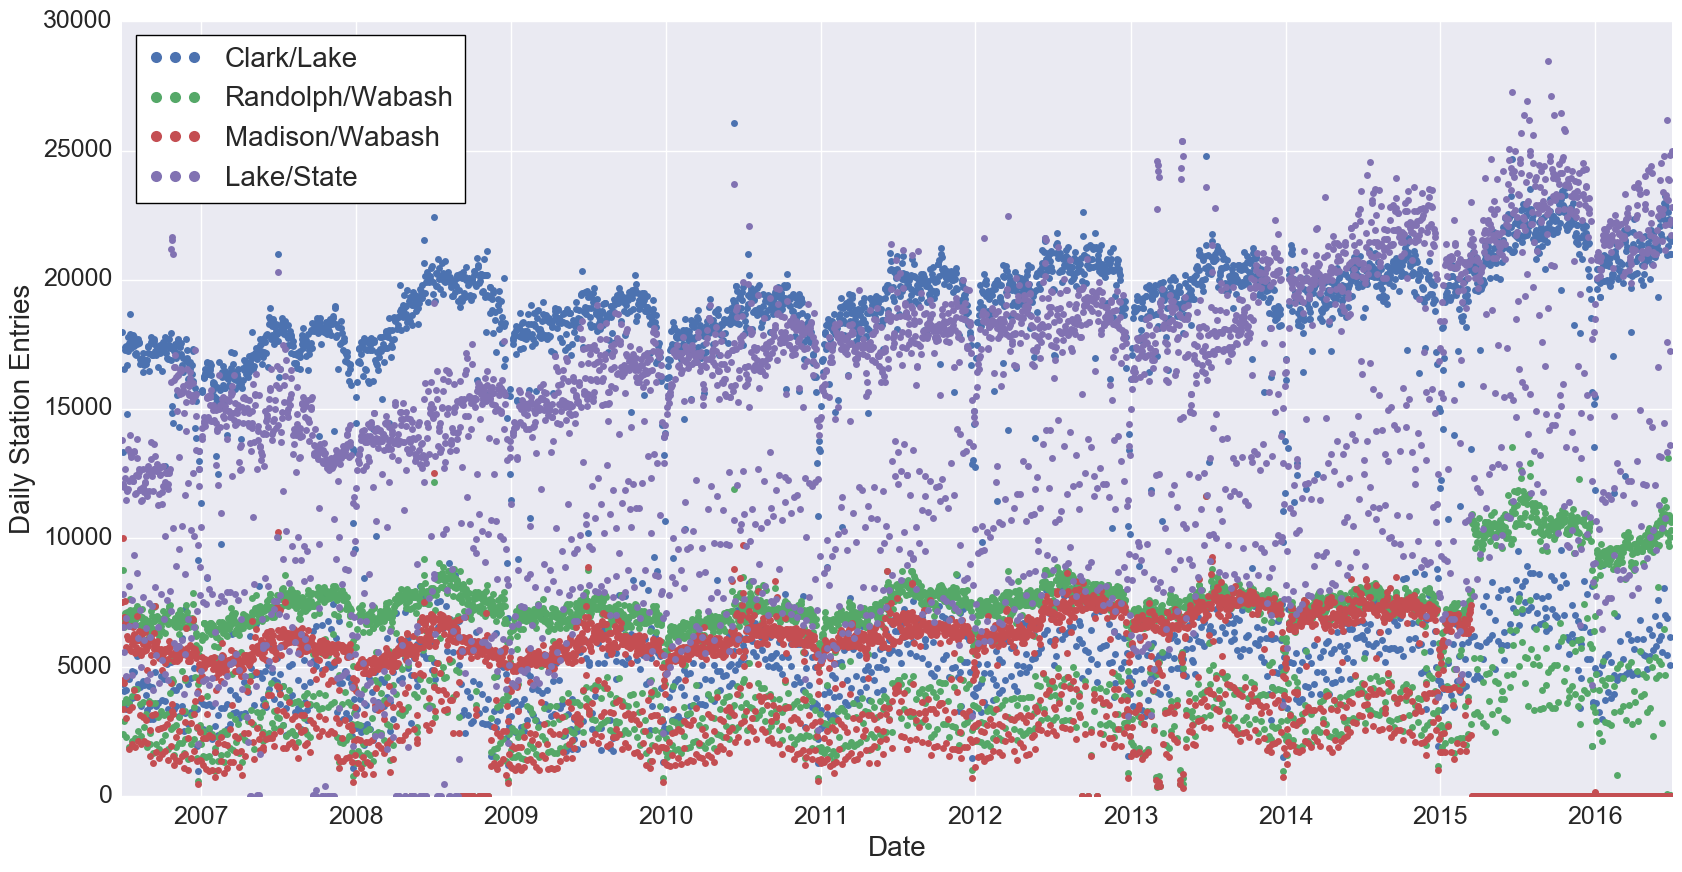

In [284]:
fig, ax = plt.subplots(figsize=(20, 10))
[ax.plot(x.date.values,x.rides.values,label=sublist_dict[idx],marker='o',markersize=5,linewidth=0,alpha=1) for idx,x in enumerate(dsub)]

legend = ax.legend(fontsize=20, frameon=True, loc='upper left', numpoints=3)
legend.get_frame().set_facecolor('w');legend.get_frame().set_edgecolor('k'); legend.get_frame().set_linewidth(1)

for x in legend.get_lines():
    x.set_markersize(8)
    x.set_alpha(1)
    x.set_marker('o')

ax.set_xlabel('Date', size=20)
ax.set_ylabel('Daily Station Entries', size=20)
#ax.set_ylim([0,40000])
ax.tick_params(axis='both', which='major', labelsize=18)

plt.show()

The plot above includes weekdays, weekends and holidays.  There is very clear seasonality, presumably due to weather considerations, and the datasets are bimodal due to the different levels of ridership on weekdays and weekends.  Holidays, and weekdays around holidays, are also clearly visible as having significantly depressed ridership.  We also notice a major structural shifts in ridership for Randolph/Wabash and Madison/Wabash in March 2015.  A quick search reveals that the CTA began demolishing the station at Madison/Wabash at that time and encouraged riders to begin using Randolph/Wabash and Adams/Wabash as alternatives:
http://loopchicago.com/blog/construction-begins-on-washington-wabash-l-loop-link

Now let's have a look at some of the stations that are missing from the geo-location dataset:

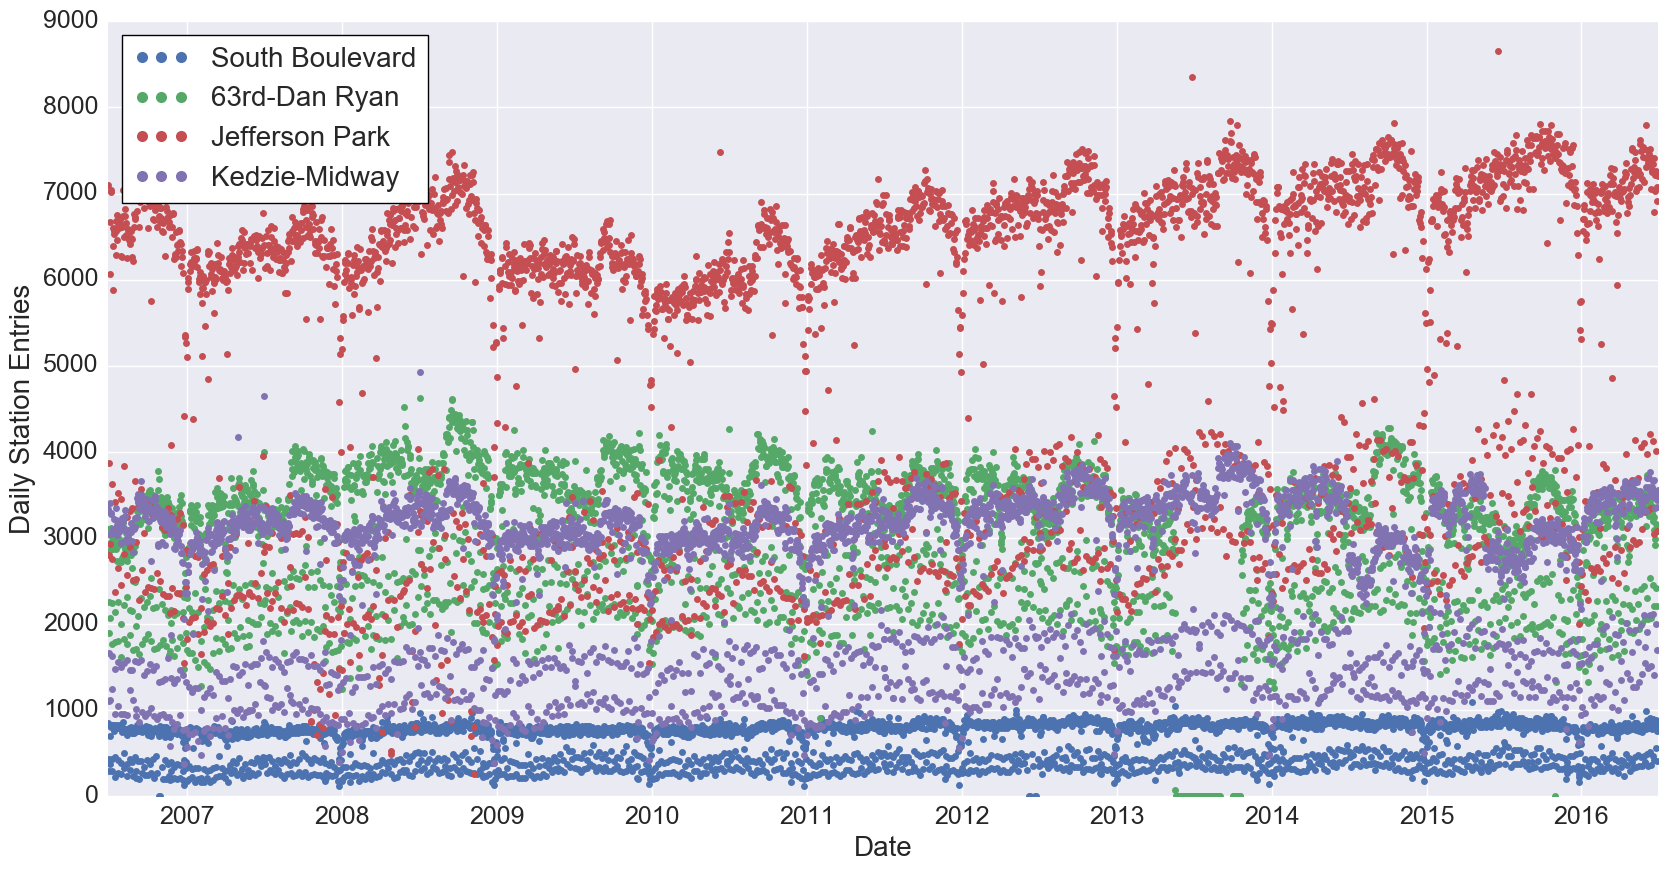

In [285]:
fig, ax = plt.subplots(figsize=(20, 10))
[ax.plot(x.date.values,x.rides.values,label=sublist_dict_nogeo[idx],marker='o',markersize=5,linewidth=0,alpha=1) for idx,x in enumerate(dsub_nogeo)]

legend = ax.legend(fontsize=20, frameon=True, loc='upper left', numpoints=3)
legend.get_frame().set_facecolor('w');legend.get_frame().set_edgecolor('k'); legend.get_frame().set_linewidth(1)

for x in legend.get_lines():
    x.set_markersize(8)
    x.set_alpha(1)
    x.set_marker('o')

ax.set_xlabel('Date', size=20)
ax.set_ylabel('Daily Station Entries', size=20)
#ax.set_ylim([0,40000])
ax.tick_params(axis='both', which='major', labelsize=18)

plt.show()

Well, they seem to have legitimate time-series data and a reasonable level of volume; we'll need (eventually) to get geo-location data for these stations manually and include them in the final analysis... but that is for another day.

-----
## Correlation between stations for mapping demographic distributions

Another important aspect of the station-entry data is the degree of correlation in the ridership of different stations.  For example, as discussed in the introduction, we might consider developing approximate mappings between stations near the end of each 'L' line and major stations in the Loop area.  With this correlation matrix, the relative scale of the ridership of each station and census-tract data, we can generate an (extremely) approximate economic/demographic distribution for the commuters in a given location.

For this specific application, we aren't really interested in correlations from a decade ago.  Let's examine the correlation between every pair of stations for the last two years.

(75, 75)

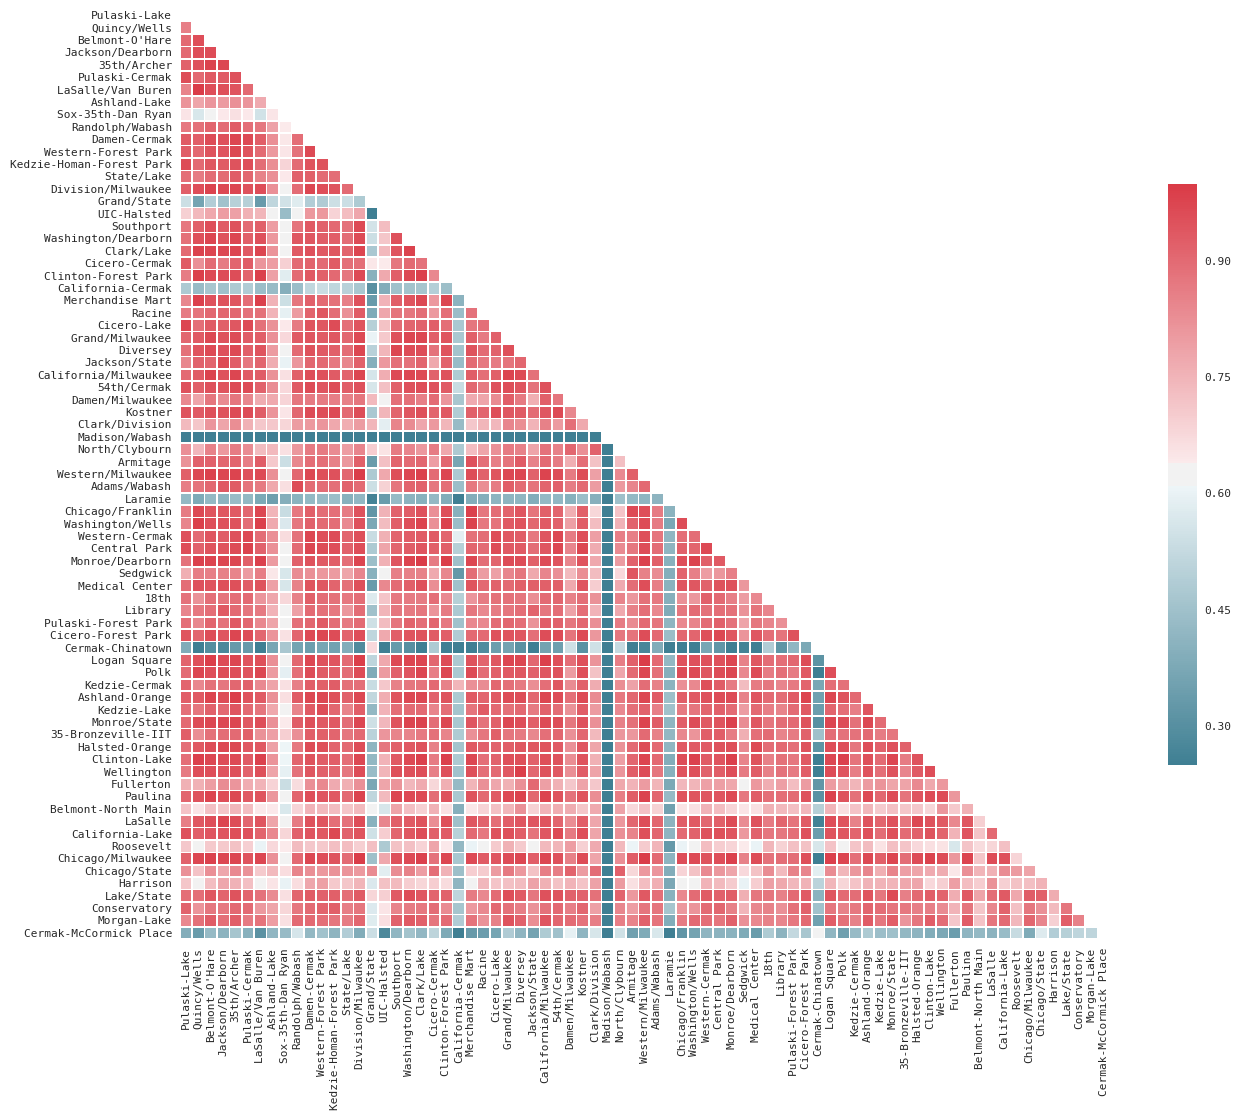

In [354]:
start_date='2014-06-30' 
end_date='2016-06-30' 
daytype=['W','A','U']
startD = pd.to_datetime(start_date)
endD = pd.to_datetime(end_date) 
dmask = (Ldata['daytype'].isin(daytype)) & (Ldata['date'] >= startD) & (Ldata['date'] <= endD)  
              
Lcorr = Ldata.copy().loc[dmask].copy()
Lcorr_date = Lcorr.set_index(['date'])

#make a list of all the station_id numbers that we want to include in our correlation analysis
station_id_corr = Ldata.station_id.unique().tolist()

#create a list of dataframes, each element having the timeseries for a single station_id
dcorr = []
df_list_filt = [Lcorr_date[Lcorr_date['station_id']==x] for x in station_id_corr]
dcorr = df_list_filt[0]
colnames = []
colnames.append("rides")

#loop through the df list and join the data together using the date, which is now the index
for idx,x in enumerate(df_list_filt[1:],1):
    dcorr = dcorr.join(x, how ='right', rsuffix='_'+str(idx))
    colnames.append('rides_'+str(idx))

#colnames.append(station_dict_rev[station_id_corr[idx]])
corr_mat = dcorr[colnames].corr()

stations_corr = [station_dict_rev[station_id_corr[i]] for i in range(len(station_id_corr))]
corr_mat.index = stations_corr
corr_mat.columns = stations_corr
display(corr_mat.shape)

#implementation from: http://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white", context="paper", font="monospace")

mask = np.zeros_like(corr_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=1, vmin=0.25, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

#sns.heatmap(corr_mat, xticklabels=corr_mat.columns.values, yticklabels=corr_mat.columns.values)
plt.show()

In [343]:
testdf = corr_mat['Lake/State'].copy()
testdf.sort(ascending=False)
display('10 most correlated with Lake/State',testdf.head(10),'10 most "negatively" correlated with Lake/State', testdf.tail(10))

'10 most correlated with Lake/State'

Lake/State              1.000000
Monroe/State            0.968064
Washington/Dearborn     0.961637
Grand/Milwaukee         0.957200
California/Milwaukee    0.953471
54th/Cermak             0.949479
35th/Archer             0.947628
Logan Square            0.945616
Ashland-Orange          0.944443
Belmont-O'Hare          0.940262
Name: Lake/State, dtype: float64

'10 most "negatively" correlated with Lake/State'

Fullerton                 0.750056
Harrison                  0.736091
UIC-Halsted               0.685344
Grand/State               0.672914
Sox-35th-Dan Ryan         0.628636
California-Cermak         0.520165
Cermak-McCormick Place    0.506612
Laramie                   0.409027
Cermak-Chinatown          0.382229
Madison/Wabash           -0.060638
Name: Lake/State, dtype: float64

-----
### As an aside:
Here is some simple code that loops through time windows for various analyses

In [9]:
maxn = 10
minn = 0
testi = 40380
winshift = 60
winsize = 90
initD = '2014-01-01'

index = list(range(minn,maxn))
cols = ['startdate','enddate']

initD = pd.to_datetime(initD)
timedf = pd.DataFrame(index = index, columns = cols)

for i in range(0,maxn):
    startD = initD + datetime.timedelta(days=i*winshift)
    endD = startD + datetime.timedelta(days=winsize)
    timedf.ix[i,['startdate','enddate']] = [startD, endD]
    
    dmask = (Ldata['station_id']==testi) & (Ldata['daytype']=='W') & (Ldata['date'] >= startD) & (Ldata['date'] <= endD)  
    Lsub = Ldata.loc[dmask]
    
    #Computations for.... stuff
    
display(timedf.head(3),Lsub.head(3))

,startdate,enddate
0,2014-01-01 00:00:00,2014-04-01 00:00:00
1,2014-03-02 00:00:00,2014-05-31 00:00:00
2,2014-05-01 00:00:00,2014-07-30 00:00:00


,station_id,stationname,date,daytype,rides,lat,lon
748942,40380,Clark/Lake,2015-06-25,W,22203,41.885737,-87.630886
748943,40380,Clark/Lake,2015-06-26,W,21326,41.885737,-87.630886
748946,40380,Clark/Lake,2015-06-29,W,21688,41.885737,-87.630886


-----
# Developing maps of commuter density

### Commuter-density model
This simple commuter-density model, which is found in the function `cdens`, uses exponential distributions for walkers and cyclists and a log-normal distribution for taxi/car-service users.  The relative weighting and parameters of each distribution were estimated using data from AASHTO (commuting in America 2013), Chicago's 2010-Census data and Velo'v data on urban cycling in Lyon, France.  Each station acts as a weighted commuter sink based on overall ridership and trends for each station. The symmetry of the distribution model should make the directionality of the data (entry vs exit) irrelevant.  For now, no effort is made to include the effects of barriers (the lake, river, railways, etc..), i.e. distribution functions are taken to be radially symmetric.  Unfortunately, this means that some of our probability mass is lost in Lake Michigan.  We can import some GIS data to handle this and redistribute that mass on land by increasing a station's signal by the appropriate factor.  Stations are color mapped according to the total # of rides.  We'll compare our various analyses and visualizations using data from a recent high-volume day.  

-----
### Commuter-density model using Euclidean distance

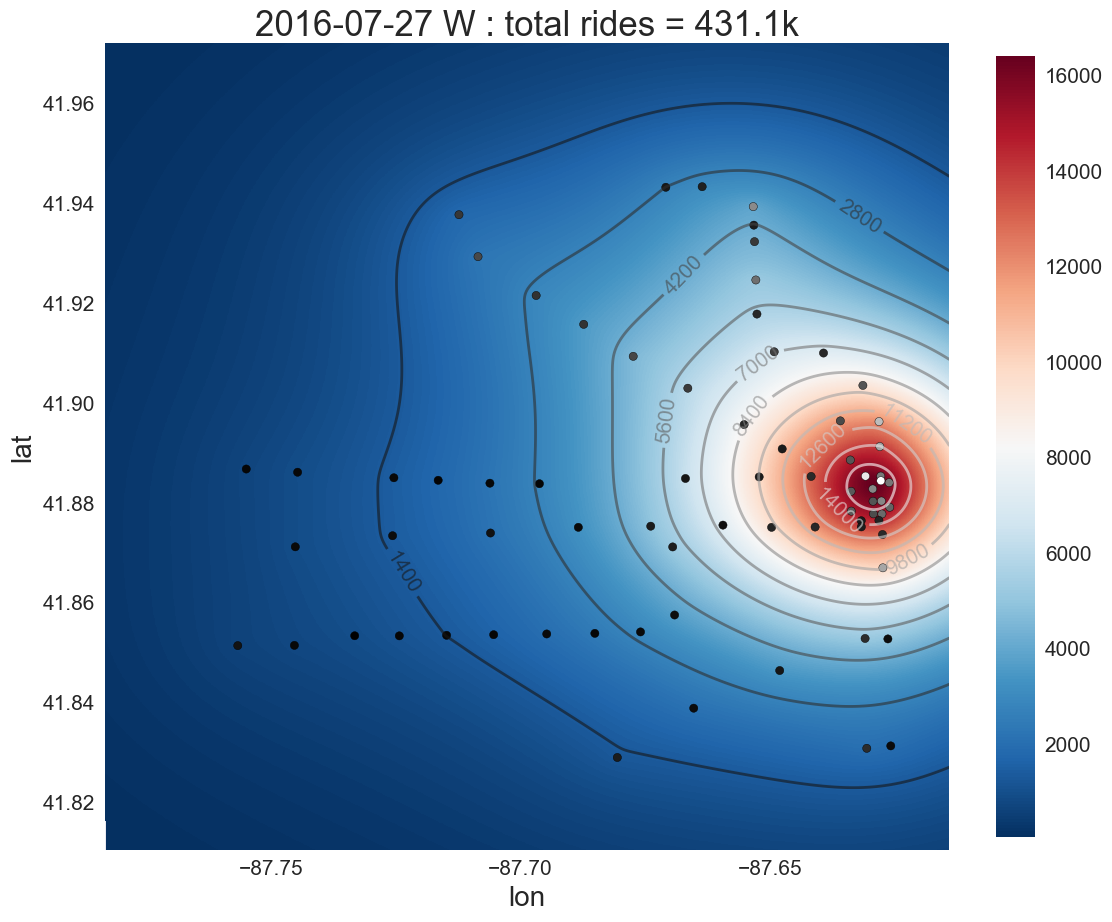

In [25]:
filtD = '2016-07-27'

Nxy = [1400,1800]
lt,ln,latdata,londata = grid_gen(xlim=[-13.,1.], ylim=[-8.,10.], Nxy=Nxy, origin=[dslat,dslon])

#perform any desired masking
dmask = (Ldata['date'] == filtD) & (Ldata['daytype'].isin(['W'])) & (Ldata['rides'] > 0)
Lsubmap = Ldata.loc[dmask]

zdata = np.zeros(Nxy[0]*Nxy[1])

#iterating through gridpoints (*note: this method was built out prior to the vectorization work in the next section; 
#vectorizing this would be relatively straightforward now)
wsum = 0
for row in Lsubmap.itertuples():
    wz = row[5]; lati = row[6]; loni = row[7];
    zdata = zdata + wz*cdens(londata, latdata, loni, lati)
    wsum = wsum + wz

zz = np.reshape(zdata,(Nxy[1],Nxy[0]))
zmin = 0; Ncon = 12;
dz = int(np.ceil((np.max(zz)-zmin)/Ncon/100.0))*100

plt.figure(figsize=(12,12))
cdensmap = plt.pcolormesh(ln,lt,zz, cmap = 'RdBu_r')
cdensmap.axes.set_ylim(np.min(lt), np.max(lt))
cdensmap.axes.set_xlim(np.min(ln), np.max(ln))
cset = plt.contour(ln, lt, zz, np.arange(zmin,np.max(zz),dz),linewidths=2,cmap='gray',alpha = 0.6)
plt.clabel(cset,inline=True,fmt='%1.0f',fontsize=15)
plt.colorbar(cdensmap, fraction=0.042)
plt.title(filtD + " " + str(Lsubmap.iloc[0]['daytype']) + " : total rides = " + str(np.around(wsum/1000,1))+"k", fontsize=25)
plt.xlabel('lon', fontsize=20)
plt.ylabel('lat', fontsize=20)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(Lsubmap.lon.values,Lsubmap.lat.values, s= 35, c=Lsubmap.rides.values, cmap ='gray')
plt.show()

We can also generate a map using the same density model but with a Manhattan distance.  Again, this helps to capture the grid-like structure of a dense urban environment, i.e. the commuters are forced to travel along predominantly North-South and East-West paths.

### Commuter-density model using Manhattan distance

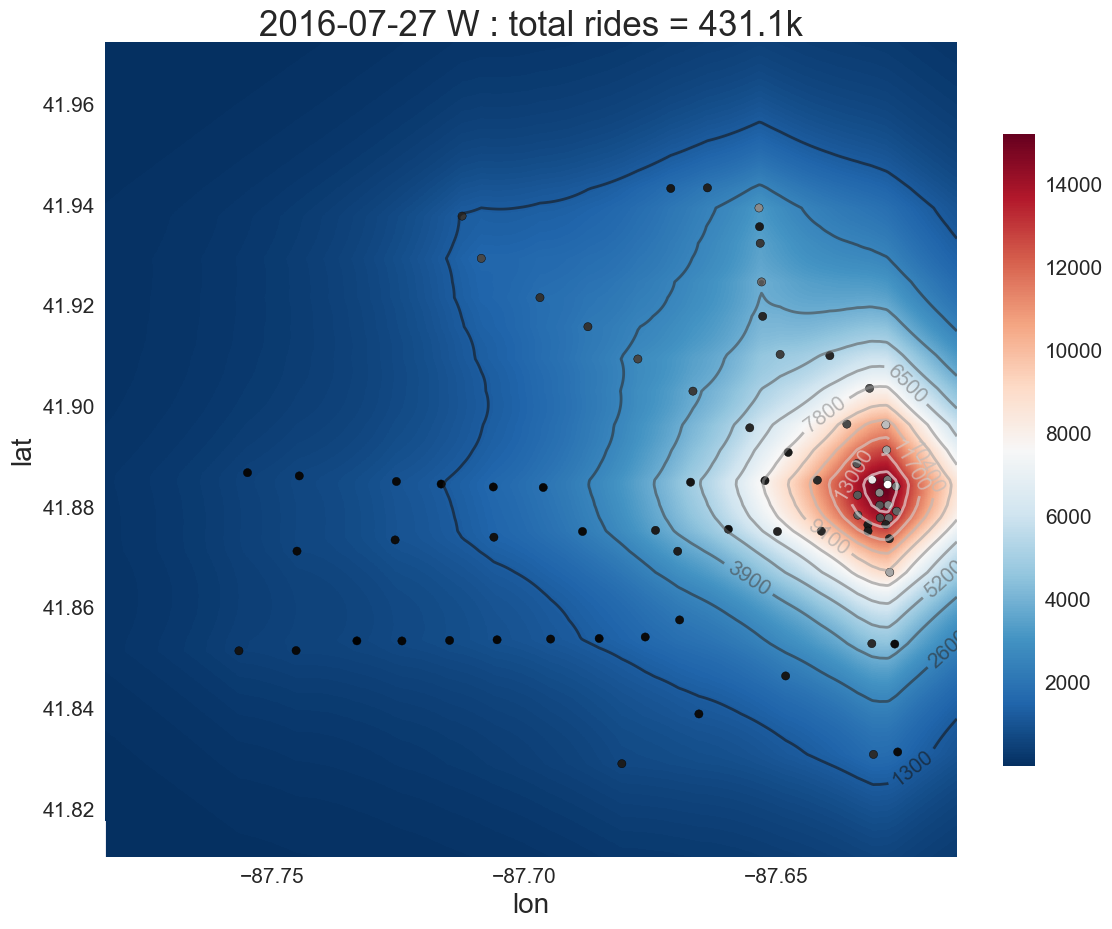

In [26]:
filtD = '2016-07-27'

#setting up xy and geo grids
Nxy = [1400,1800]
lt,ln,latdata,londata = grid_gen(xlim=[-13.,1.], ylim=[-8.,10.], Nxy=Nxy, origin=[dslat,dslon])

#perform any desired masking
dmask = (Ldata['date'] == filtD) & (Ldata['daytype'].isin(['W'])) & (Ldata['rides'] > 0)
Lsubmap = Ldata.loc[dmask]

zdata = np.zeros(Nxy[0]*Nxy[1])

#iterating through gridpoints (*note: this method was built out prior to the vectorization work in the next section; 
#vectorizing this would be relatively straightforward now)
wsum = 0
for row in Lsubmap.itertuples():
    wz = row[5]; lati = row[6]; loni = row[7];
    zdata = zdata + wz*cdens_manhattan(londata, latdata, loni, lati)
    wsum = wsum + wz

zz = np.reshape(zdata,(Nxy[1],Nxy[0]))
zmin = 0; Ncon = 12;
dz = int(np.ceil((np.max(zz)-zmin)/Ncon/100.0))*100

plt.figure(figsize=(12,12))
cdensmap = plt.pcolormesh(ln,lt,zz, cmap = 'RdBu_r')
cdensmap.axes.set_ylim(np.min(lt), np.max(lt))
cdensmap.axes.set_xlim(np.min(ln), np.max(ln))
cset = plt.contour(ln, lt, zz, np.arange(zmin,np.max(zz),dz),linewidths=2,cmap='gray',alpha = 0.6)
plt.clabel(cset,inline=True,fmt='%1.0f',fontsize=15)
plt.colorbar(cdensmap, fraction=0.034)
plt.title(filtD + " " + str(Lsubmap.iloc[0]['daytype']) + " : total rides = " + str(np.around(wsum/1000,1))+"k", fontsize=25)
plt.xlabel('lon', fontsize=20)
plt.ylabel('lat', fontsize=20)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(Lsubmap.lon.values,Lsubmap.lat.values, s= 35, c=Lsubmap.rides.values, cmap ='gray')
plt.show()

The diamond-shaped isopleths characteristic of the Manhattan distance are clear; these arise because the most efficient way to cover distance when constrained to a grid is by moving along an axis of that grid without turning.  Since people have a (perhaps implicit) distance limit that they are willing to travel, locations that are "grid aligned" with high-volume stations will be more optimal than those requiriong significant travel on both grid axes.  

-----
## Computing Voronoi diagrams for higher spatial resolution

As an alternative means of estimating commuter density, we incorporate a simple commuter decision model in which a commuter in a given location will alway choose to go to the closest station. This type of discretization is known as a Voronoi diagram, and we build these diagrams for two different distance metrics: Euclidean (actually the haversine distance, but they are close enough on this length scale) and Manhattan. The Manhattan version is meant to capture the effect of commuters being forced to travel along the grid-like structure of a major city; i.e. the paths are constrained to be North-South and East-West, and the Manhattan distance enforces this explicitly.  For computing the Manhattan distance between each grid point and each station, we compute the haversine distance for two orthogonal legs: latitude only and longitude only.

The color of each cell in the Voronoi diagrams reflects the average commuter density for that area. It is computed by dividing the number of turnstile activations of the station in that cell by the total number of discrete grid points that were assigned to that station. The actual density is appropriately scaled by the area per grid point.  This approach allows us to compute actual densities but with greater granularity than the trip-distance PDF approach above.

-----
### Commuter-density Voronoi diagram with Euclidean distance: 

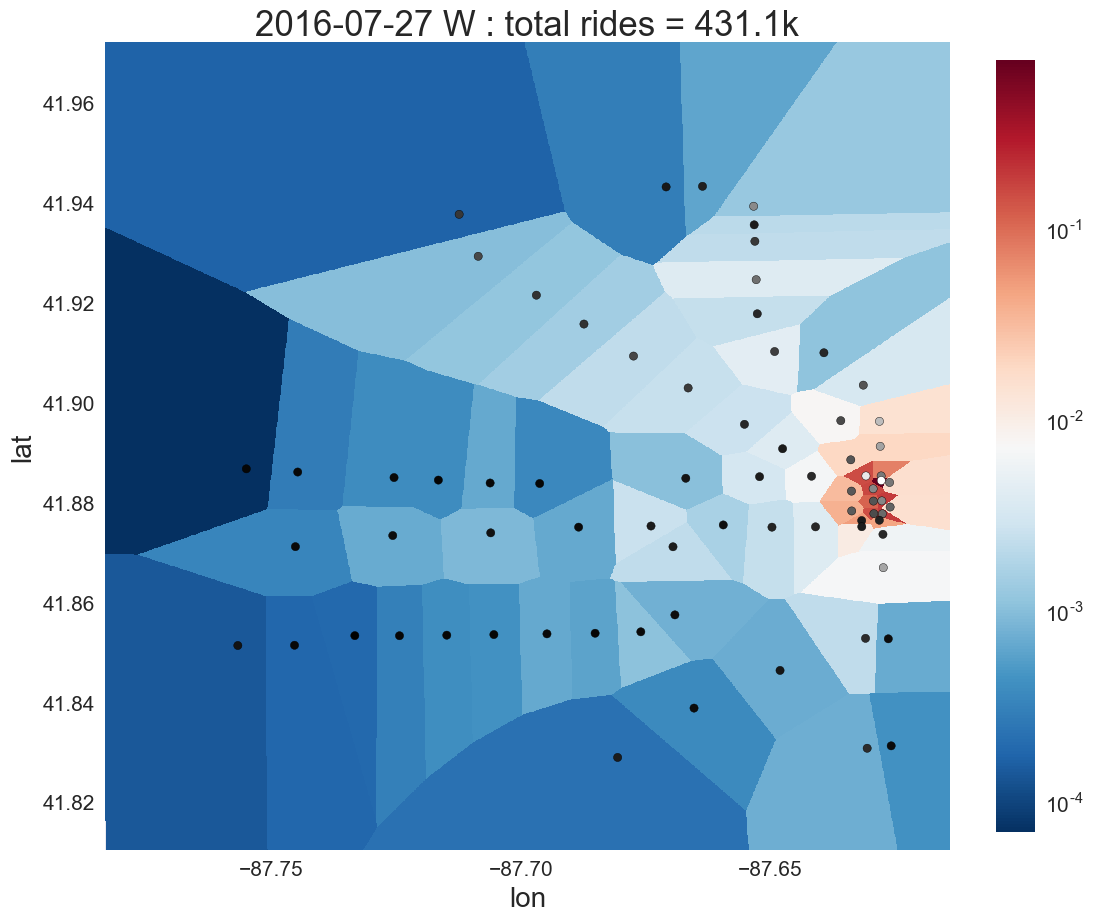

In [27]:
#setting up xy and geo grids
xlim = [-13.,1.]
Nxy = [1400,1800]
dA = ((xlim[1]-xlim[0])*1000./Nxy[0])**2
lt,ln,latdata,londata = grid_gen(xlim=xlim, ylim=[-8.,10.], Nxy=Nxy, origin=[dslat,dslon])

#setting up station and grid geo data for distance computation
latmat = np.asmatrix(Lsubmap.lat.values); lonmat = np.asmatrix(Lsubmap.lon.values)
latM = np.asmatrix(latdata).transpose(); lonM = np.asmatrix(londata).transpose()

#vectorized computation of distances and determination of closest station for a given grid point; adding rides col as well 
clustDF = pd.DataFrame(np.argmin(nphaversine(latM,lonM,latmat,lonmat),1),columns=['clusterID'])
clustDF['rides'] = np.asarray(Lsubmap.iloc[clustDF['clusterID'],4])

#counting up how many grid points (i.e. how much area) have been assigned to each station; building dictionary for mapping
gclust = clustDF.groupby('clusterID').size()
scale = dict(zip(gclust.index, gclust))

#mapping the appropriate commuter density to each point
clustDF['density'] = clustDF['rides']/clustDF['clusterID'].map(scale)/dA
clustzz = np.reshape(clustDF['density'],(Nxy[1],Nxy[0]))

zmin = 0; Ncon = 12;
dz = int(np.ceil((np.max(clustzz)-zmin)/Ncon/100.0))*100

plt.figure(figsize=(12,12))
cdensmap = plt.pcolormesh(ln,lt,clustzz, cmap = 'RdBu_r', norm=LogNorm())
cdensmap.axes.set_ylim(np.min(lt), np.max(lt))
cdensmap.axes.set_xlim(np.min(ln), np.max(ln))
cset = plt.contour(ln, lt, clustzz, np.arange(zmin,np.max(clustzz),dz),linewidths=2,cmap='gray',alpha = 0.6)
plt.clabel(cset,inline=True,fmt='%1.0f',fontsize=15)
plt.colorbar(cdensmap, fraction=0.0415)
plt.title(filtD + " " + str(Lsubmap.iloc[0]['daytype']) + " : total rides = " + str(np.around(wsum/1000.,1))+"k", fontsize=25)
plt.xlabel('lon', fontsize=20)
plt.ylabel('lat', fontsize=20)

plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(Lsubmap.lon.values,Lsubmap.lat.values, s= 35, c=Lsubmap.rides.values, cmap ='gray')
plt.show()

As in the map we generated with the simple commuter-density model, the Loop area dominates the Voronoi diagram; however, we now have significantly more granularity in our map.  Unfortunately, the Euclidean-distance metric doesn't capture the grid-like nature of a dense, downtown area; for this we'll try using at the appropriately named Manhattan distance.

-----
### Commuter-density Voronoi diagram with Manhattan distance:

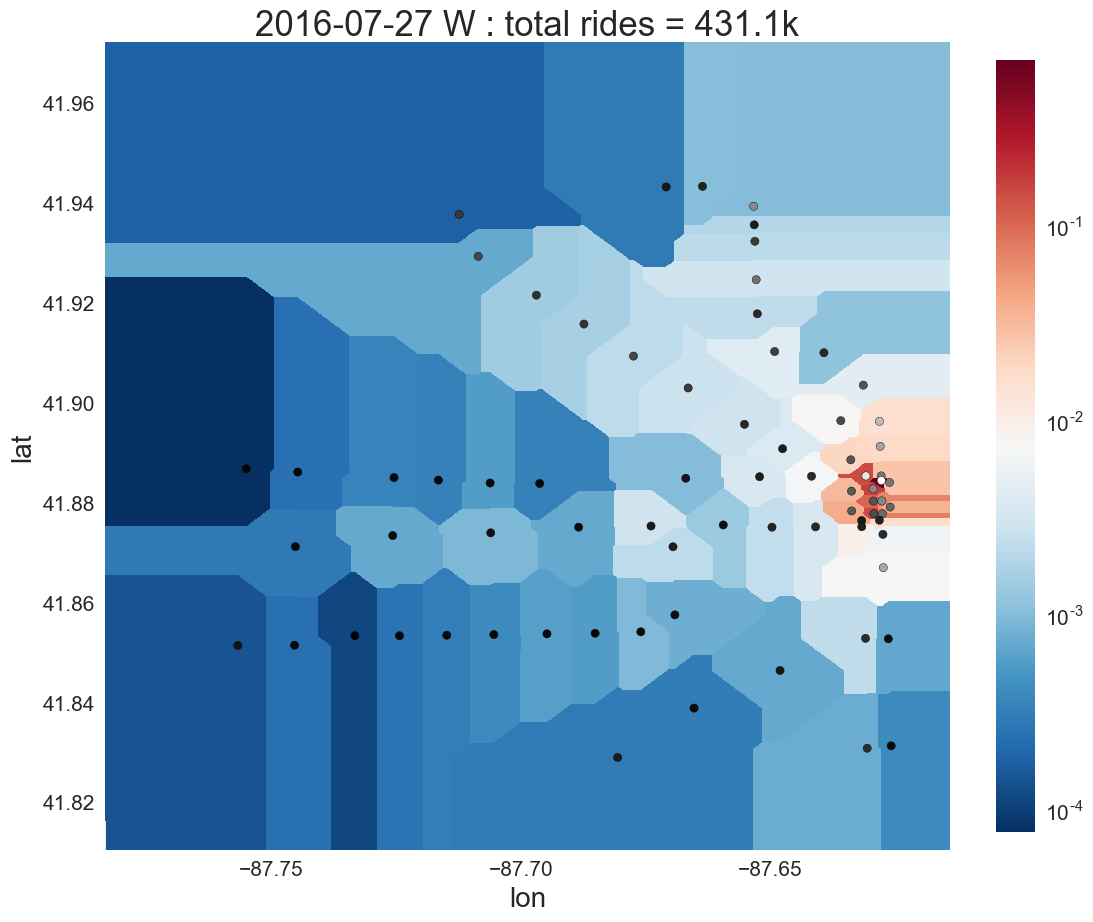

In [28]:
#setting up xy and geo grids
xlim = [-13.,1.]
Nxy = [1400,1800]
dA = ((xlim[1]-xlim[0])*1000./Nxy[0])**2
lt,ln,latdata,londata = grid_gen(xlim=xlim, ylim=[-8.,10.], Nxy=Nxy, origin=[dslat,dslon])

#setting up station and grid geo data for distance computation
latmat = np.asmatrix(Lsubmap.lat.values); lonmat = np.asmatrix(Lsubmap.lon.values)
latM = np.asmatrix(latdata).transpose(); lonM = np.asmatrix(londata).transpose()

#vectorized computation of distances and determination of closest station for a given grid point; adding rides col as well 
clustDF = pd.DataFrame(np.argmin(nphaversine_manhattan(latM,lonM,latmat,lonmat),1),columns=['clusterID'])
clustDF['rides'] = np.asarray(Lsubmap.iloc[clustDF['clusterID'],4])

#counting up how many grid points (i.e. how much area) have been assigned to each station; building dictionary for mapping
gclust = clustDF.groupby('clusterID').size()
scale = dict(zip(gclust.index, gclust))

#mapping the appropriate commuter density to each point
clustDF['density'] = clustDF['rides']/clustDF['clusterID'].map(scale)/dA
clustzz_m = np.reshape(clustDF['density'],(Nxy[1],Nxy[0]))

zmin = 0; Ncon = 12;
dz = int(np.ceil((np.max(clustzz_m)-zmin)/Ncon/100.0))*100

plt.figure(figsize=(12,12))
cdensmap = plt.pcolormesh(ln,lt,clustzz_m, cmap = 'RdBu_r', norm=LogNorm())
cdensmap.axes.set_ylim(np.min(lt), np.max(lt))
cdensmap.axes.set_xlim(np.min(ln), np.max(ln))
#cset = plt.contour(ln, lt, clustzz, np.arange(zmin,np.max(clustzz),dz),linewidths=2,cmap='gray',alpha = 0.6)
#plt.clabel(cset,inline=True,fmt='%1.0f',fontsize=15)
plt.colorbar(cdensmap, fraction=0.0415)
plt.title(filtD + " " + str(Lsubmap.iloc[0]['daytype']) + " : total rides = " + str(np.around(wsum/1000.,1))+"k", fontsize=25)
plt.xlabel('lon', fontsize=20)
plt.ylabel('lat', fontsize=20)

plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(Lsubmap.lon.values,Lsubmap.lat.values, s= 35, c=Lsubmap.rides.values, cmap ='gray')
plt.show()

In practice, everyone isn't going to be thinking about which distance metric is more appropriate for their trip; furthermore, there are areas like a wide-open park where a straightline path would be natural and others where a Manhattan path is the only one that can be taken, e.g. in a dense area of skyscrapers.  A simple way to capture this randomness is to take a linear combination of the Euclidean and Manhattan results.  The map below shows a simple average of the two maps.

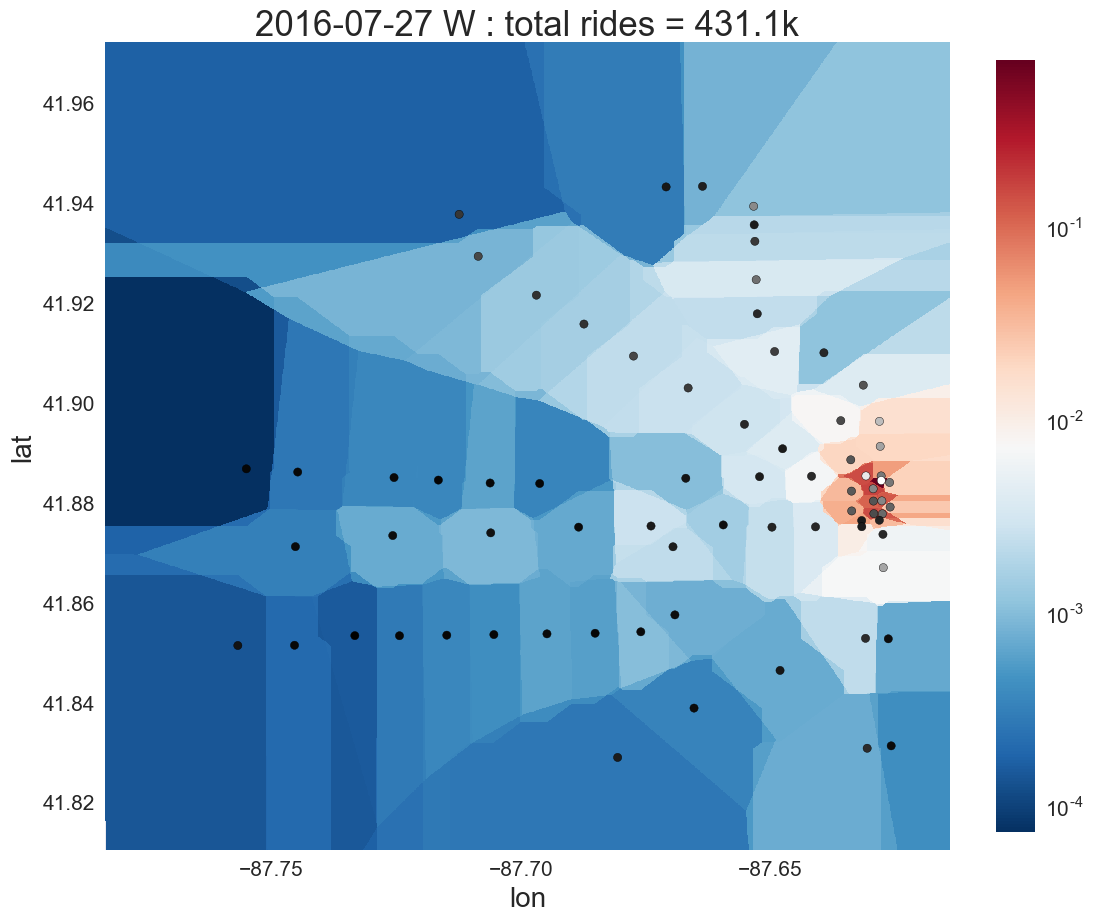

In [29]:
clustzz_comp = (clustzz + clustzz_m)/2
zmin = 0; Ncon = 12;
dz = int(np.ceil((np.max(clustzz_comp)-zmin)/Ncon/100.0))*100

plt.figure(figsize=(12,12))
cdensmap = plt.pcolormesh(ln,lt,clustzz_comp, cmap = 'RdBu_r', norm=LogNorm())
cdensmap.axes.set_ylim(np.min(lt), np.max(lt))
cdensmap.axes.set_xlim(np.min(ln), np.max(ln))
#cset = plt.contour(ln, lt, clustzz, np.arange(zmin,np.max(clustzz),dz),linewidths=2,cmap='gray',alpha = 0.6)
#plt.clabel(cset,inline=True,fmt='%1.0f',fontsize=15)
plt.colorbar(cdensmap, fraction=0.0415)
plt.title(filtD + " " + str(Lsubmap.iloc[0]['daytype']) + " : total rides = " + str(np.around(wsum/1000.,1))+"k", fontsize=25)
plt.xlabel('lon', fontsize=20)
plt.ylabel('lat', fontsize=20)

plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(Lsubmap.lon.values,Lsubmap.lat.values, s= 35, c=Lsubmap.rides.values, cmap ='gray')
plt.show()

Finally, we might also consider combining the two model types: commuter-density and commuter-decision.  To do this, we'll normalize the Manhattan version of the commuter-density map to its maximum value and convolve this with our mixed commuter-decision map.  This will give us some realistic spatial variation across larger clusters, something that the Voronoi maps lack.

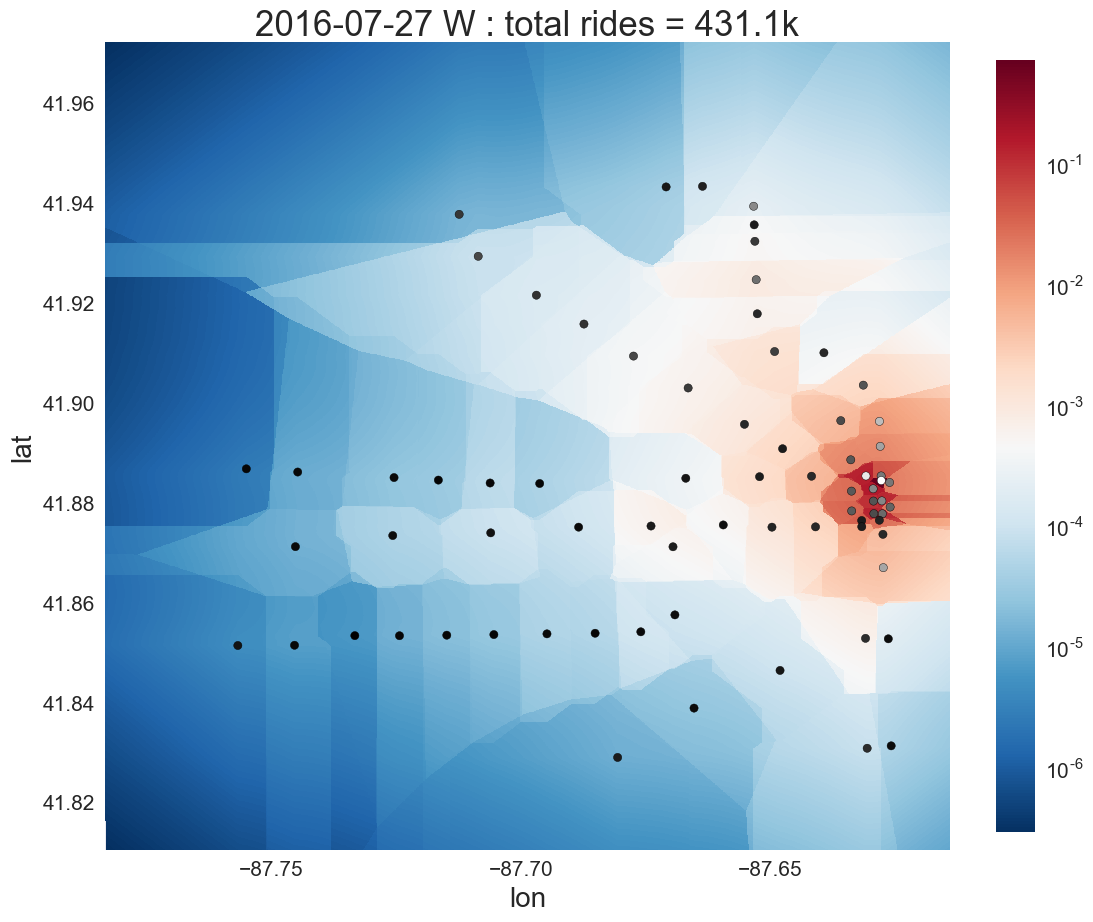

In [30]:
zz_norm = zz/np.max(zz)
map_total = zz_norm*clustzz_comp

plt.figure(figsize=(12,12))
cdensmap = plt.pcolormesh(ln,lt,map_total, cmap = 'RdBu_r', norm=LogNorm())
cdensmap.axes.set_ylim(np.min(lt), np.max(lt))
cdensmap.axes.set_xlim(np.min(ln), np.max(ln))
#cset = plt.contour(ln, lt, clustzz, np.arange(zmin,np.max(clustzz),dz),linewidths=2,cmap='gray',alpha = 0.6)
#plt.clabel(cset,inline=True,fmt='%1.0f',fontsize=15)
plt.colorbar(cdensmap, fraction=0.0415)
plt.title(filtD + " " + str(Lsubmap.iloc[0]['daytype']) + " : total rides = " + str(np.around(wsum/1000.,1))+"k", fontsize=25)
plt.xlabel('lon', fontsize=20)
plt.ylabel('lat', fontsize=20)

plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(Lsubmap.lon.values,Lsubmap.lat.values, s= 35, c=Lsubmap.rides.values, cmap ='gray')
plt.show()

And for a tight zoom on the Loop:

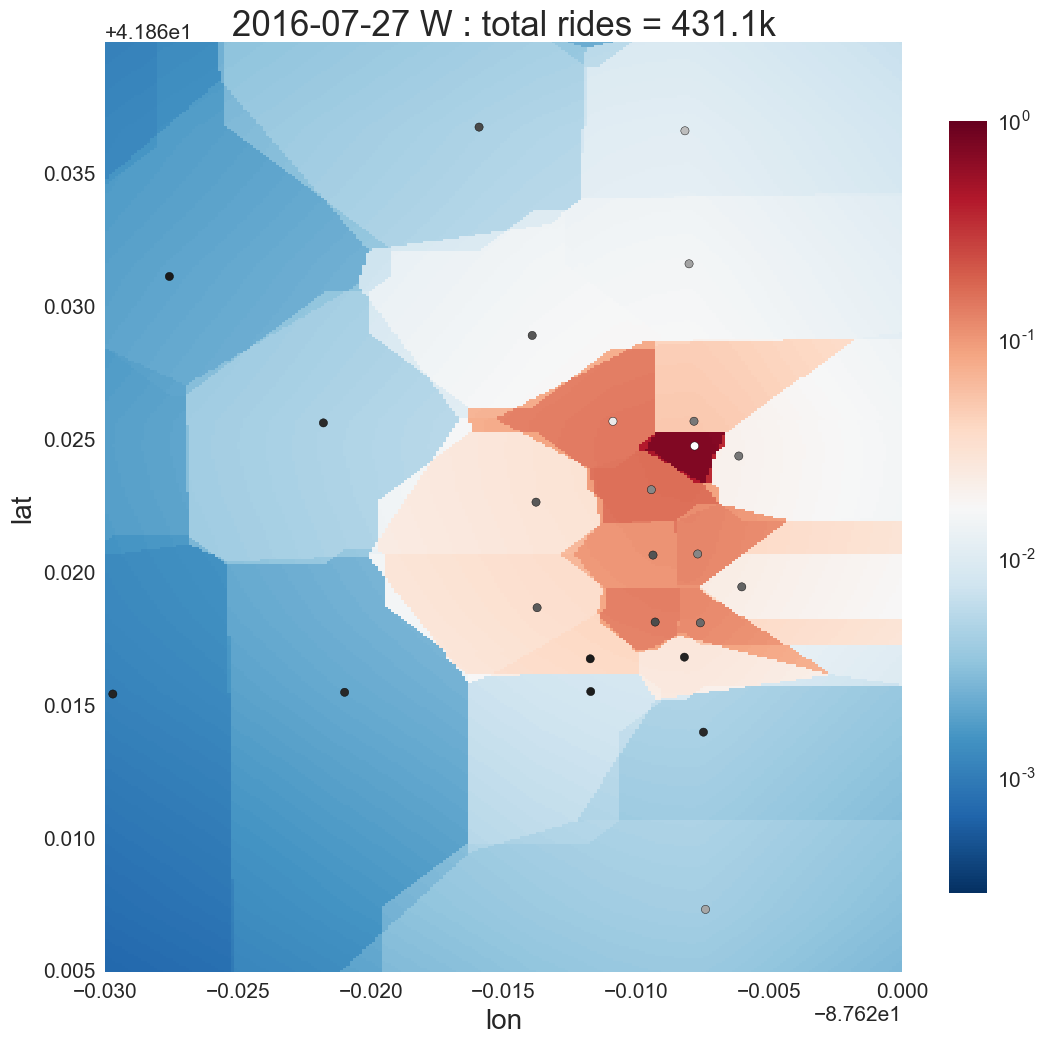

In [155]:
plt.figure(figsize=(12,12))
cdensmap = plt.pcolormesh(ln,lt,map_total, cmap = 'RdBu_r', norm=LogNorm())
cdensmap.axes.set_ylim(41.865, 41.9)
cdensmap.axes.set_xlim(-87.65, -87.62)
#cset = plt.contour(ln, lt, clustzz, np.arange(zmin,np.max(clustzz),dz),linewidths=2,cmap='gray',alpha = 0.6)
#plt.clabel(cset,inline=True,fmt='%1.0f',fontsize=15)
plt.colorbar(cdensmap, fraction=0.0415)
plt.title(filtD + " " + str(Lsubmap.iloc[0]['daytype']) + " : total rides = " + str(np.around(wsum/1000.,1))+"k", fontsize=25)
plt.xlabel('lon', fontsize=20)
plt.ylabel('lat', fontsize=20)

plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(Lsubmap.lon.values,Lsubmap.lat.values, s= 35, c=Lsubmap.rides.values, cmap ='gray')
cdensmap.set_clim(vmin=.0003, vmax=1)
plt.show()

Next up is probably to score each location by looking at the temporal variance and trend.  After that I'll work on importing Chicago's census tracts to begin developing a "value map" based on a variety of economic metrics.  Also on the GIS front, it should be reasonably straightforward to enforce zero commuter density in the lake.

In [18]:
# Code for scoring geographic grid points based on property values - values at either extreme are 
# penalized with an appropriate structure 

In [19]:
# Convolution of weighted commuter-density map and property-score map gives suggestions for optimum
# locations.  Method can be extended with other data, e.g. divvy locations, bus and METRA data, 
# crime statistics; additional filtering of candidate locations in consultation with client